# How to Induce Inequlity



In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import functions as F

We can simulate values with a mean and standard deviation derived from real athlete data.<br>
Specifically we can use the times for the 100m dash recorded by male athletes in 2019.

In [32]:
dash_data = pd.read_csv("100m_men_2019.csv")
dash_data

,rank,mark,wind,competitor,dob,nat,pos,empty_col,venue,date,results_score
0,1,9.76,0.6,Christian COLEMAN,06 MAR 1996,USA,1f,NaN,"Khalifa International Stadium, Doha (QAT)",28 SEP 2019,1291
1,2,9.81,-0.1,Christian COLEMAN,06 MAR 1996,USA,1,NaN,"Palo Alto, CA (USA)",30 JUN 2019,1273
2,3,9.85,0.9,Christian COLEMAN,06 MAR 1996,USA,1,NaN,"Bislett, Oslo (NOR)",13 JUN 2019,1259
3,4,9.86,0.9,Noah LYLES,18 JUL 1997,USA,1,NaN,"SS, Shanghai (CHN)",18 MAY 2019,1255
4,4,9.86,0.9,Christian COLEMAN,06 MAR 1996,USA,2,NaN,"SS, Shanghai (CHN)",18 MAY 2019,1255
...,...,...,...,...,...,...,...,...,...,...,...
21450,20972,11.00,0.7,Dawson HARCH,2002,AUS,3,NaN,"Barlow Park, Cairns (AUS)",20 OCT 2019,886
21451,20972,11.00,1.8,Hikari EGUCHI,30 SEP 1999,JPN,8h4,NaN,"Honjo Athletic Stadium, Kitakyushu (JPN)",27 OCT 2019,886
21452,20972,11.00,1.9,Schuyler ORR,25 JUN 1998,NZL,2f7,NaN,"The Caledonian Ground, Dunedin (NZL)",02 NOV 2019,886
21453,20972,11.00,1.9,Juan CAMERA,05 OCT 1996,ARG,5,NaN,Buenos Aires (ARG),09 NOV 2019,886


Results are truncated above 11 seconds. I assume this is the minimal time required to be considered a professional athlete.<br>
If this had not been the case I expect the times would have been normally distributed.

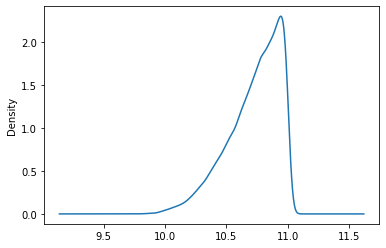

In [33]:
dash_data['mark'].plot.kde()
plt.savefig('figures/athlete_data_trunc.png')

In [34]:
mark_mean_var = dash_data.groupby('competitor').agg({'mark':['mean', 'var', 'std']})
mark_mean_var

mark                    
                   mean       var       std
competitor                                 
. AMARJEET    10.930000       NaN       NaN
. AMIT        10.885000  0.002450  0.049497
. ASHISH      10.980000       NaN       NaN
. KAPIL       10.930000       NaN       NaN
. NUZRAT      10.740000  0.005700  0.075498
...                 ...       ...       ...
Łukasz ŻOK    10.891429  0.006714  0.081941
Šimon BUJNA   10.766250  0.015684  0.125235
Štěpán HAMPL  10.642174  0.024763  0.157363
Žiga BENKO    10.846000  0.004580  0.067676
​Demish GAYE  10.480000       NaN       NaN

[6062 rows x 3 columns]

We can remove athletes that may have had truncated observations by retaining only records corresponding to athletes who had a mean time below a certain threshold.

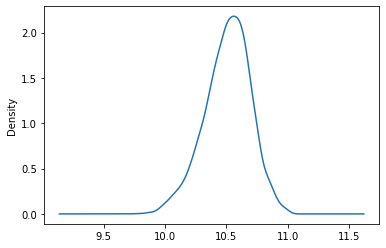

In [35]:
athletes = set(mark_mean_var[(mark_mean_var['mark']['mean'] <= 10.685)].index.tolist())
dash_data_detrunc = dash_data.loc[dash_data['competitor'].isin(athletes)]
dash_data_detrunc['mark'].plot.kde()
plt.savefig('figures/athlete_data_detrunc.png')

In [36]:
mark__mean_var_detrunc = dash_data_detrunc.groupby('competitor').agg({'mark':['mean', 'var', 'std']})

In [37]:
population_mean = mark__mean_var_detrunc['mark']['mean'].mean()
population_std = mark__mean_var_detrunc['mark']['mean'].std()
# population_std = 0
individual_std = mark__mean_var_detrunc['mark']['std'].mean()
print(population_mean)
print(population_std)
print(individual_std)

10.536215672889773
0.12884463836723445
0.11283454821402329


### Exponential proportional rewards

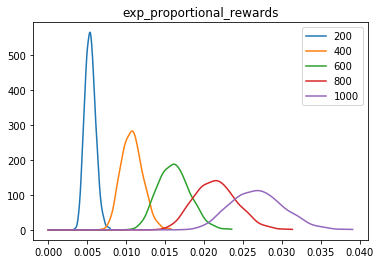

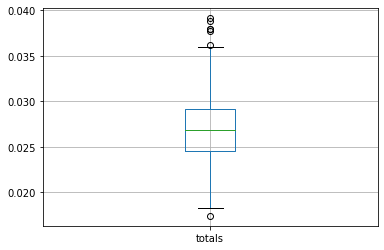

In [48]:
seeds_epr = F.initialize_seeds(size=1024, mean=population_mean, st_dev=population_std)
F.simulate(seeds_epr, 1001, individual_std, 
           F.proportional_rewards, F.exp_proportional_rewards, save=True, size=1024,
          slope = -1, intercept = 0)
seeds_epr.boxplot(column=['totals'])
plt.savefig('figures/epr_boxplot.png')

### Linear proportional rewards

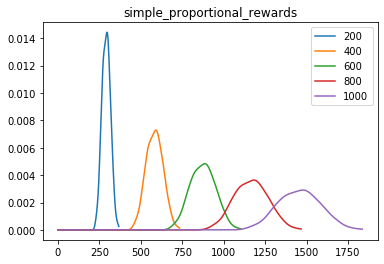

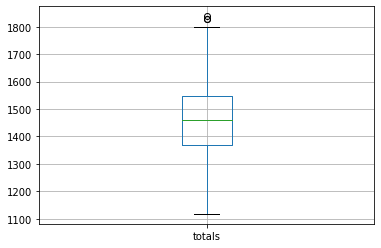

In [39]:
seeds_pr = F.initialize_seeds(size=1024, mean=population_mean, st_dev=population_std)
F.simulate(seeds_pr, 1001, individual_std,
         F.proportional_rewards, F.simple_proportional_rewards, save=True, size=1024, slope=-1, intercept=12)
seeds_pr.boxplot(column=['totals'])
plt.savefig('figures/lpr_boxplot.png')

### Snooker rank rewards

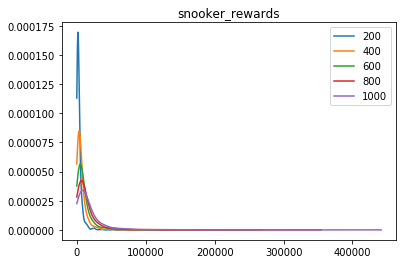

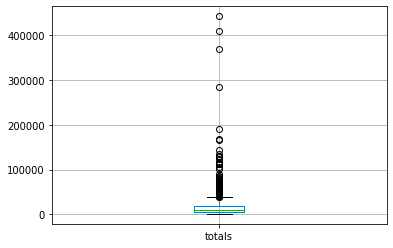

In [40]:
seeds_sr = F.initialize_seeds(size=1024, mean=population_mean, st_dev=population_std)
F.simulate(seeds_sr, 1001, individual_std,
         F.rank_rewards, F.snooker_rewards, save=True, size=1024)
seeds_sr.boxplot(column=['totals'])
plt.savefig('figures/sr_boxplot.png')

### Linear rank rewards

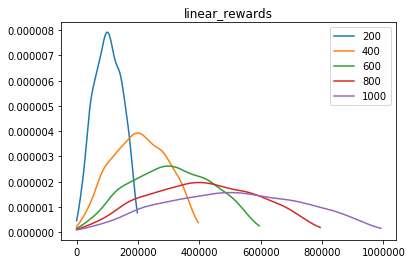

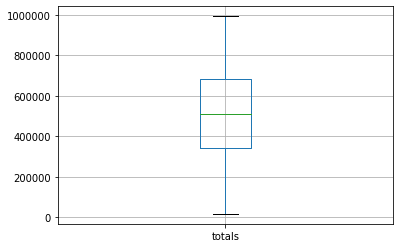

In [41]:
seeds_lr = F.initialize_seeds(size=1024, mean=population_mean, st_dev=population_std)
F.simulate(seeds_lr, 1001, individual_std,
         F.rank_rewards, F.linear_rewards, save=True, size=1024, slope=1, intercept=0)
seeds_lr.boxplot(column=['totals'])
plt.savefig('figures/lr_boxplot.png')

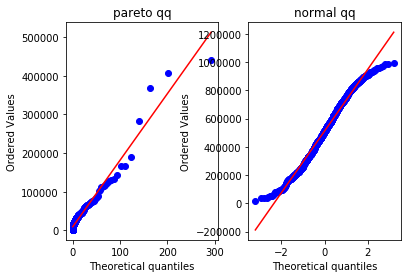

In [42]:
from scipy import stats


fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
res = stats.probplot(seeds_sr['totals'].to_numpy(), plot=plt, dist=stats.weibull_min(c=0.35, scale=1))
ax.set_title("pareto qq")

# ax2 = fig.add_subplot(1, 2, 1)
# res = stats.probplot(seeds_sr['totals'].to_numpy(), plot=plt, dist=stats.lognorm(s=1.25))
# ax2.set_title("t qq")

ax3 = fig.add_subplot(1, 2, 2)
res = stats.probplot(seeds_lr['totals'].to_numpy(), plot=plt, dist=stats.norm())
ax3.set_title("normal qq")

plt.show()

### Monotonical transformations

In [43]:
X = np.random.normal(0, 1, 10000)
Y_lin = 5 + 3 * X
Y_exp = np.exp(X)

In [44]:
def hist_with_stats(data, file_name):
    mu = np.mean(data)
    median = np.median(data)
    sigma = np.std(data)
    textstr = '\n'.join((
        r'$\mu=%.2f$' % (mu, ),
        r'$\mathrm{median}=%.2f$' % (median, ),
        r'$\sigma=%.2f$' % (sigma, )))

    fig, ax = plt.subplots()

    # these are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

    # place a text box in upper left in axes coords
    ax.text(0.65, 0.8, textstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', horizontalalignment='left', bbox=props)
    ax.hist(data, bins=100)
    plt.savefig(f'figures/{file_name}.png')
    plt.show()

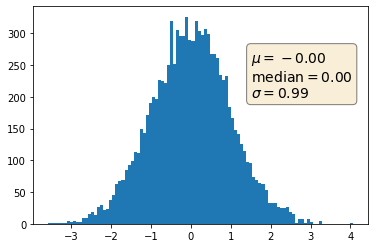

In [45]:
hist_with_stats(X, 'rand_norm_hist')

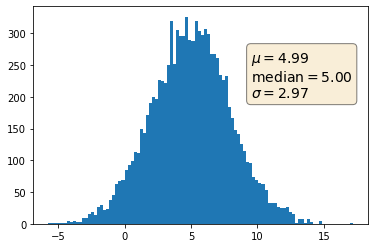

In [46]:
hist_with_stats(Y_lin, 'linear_transform_hist')

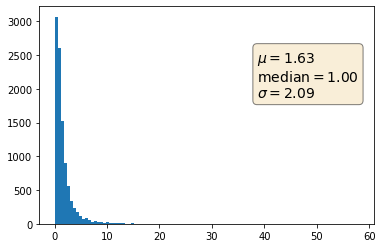

In [47]:
hist_with_stats(Y_exp, 'exp_transform_hist')